# 气象数据

字段解释:

- province
- rain1h
- temperature
- windSpeed
- tempDiff
- pressure
- rain12h
- city_index
- rain6h
- time
- city_name
- humidity
- windDirection
- city_code
- rain24h

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf

conf = SparkConf().setAppName('weather').setMaster('local[4]')
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [7]:
weather_df = spark.read.csv("weather/passed_weather_ALL.csv", header=True)

In [17]:
weather_df.printSchema()

root
 |-- province: string (nullable = true)
 |-- rain1h: string (nullable = true)
 |-- temperature: string (nullable = true)
 |-- windSpeed: string (nullable = true)
 |-- tempDiff: string (nullable = true)
 |-- pressure: string (nullable = true)
 |-- rain12h: string (nullable = true)
 |-- city_index: string (nullable = true)
 |-- rain6h: string (nullable = true)
 |-- time: string (nullable = true)
 |-- city_name: string (nullable = true)
 |-- humidity: string (nullable = true)
 |-- windDirection: string (nullable = true)
 |-- city_code: string (nullable = true)
 |-- rain24h: string (nullable = true)



In [31]:
from pyspark.sql.types import * 
import pyspark.sql.functions as F

In [28]:
weather_df.select(weather_df['time'].cast(TimestampType())).rdd.max()

Row(time=datetime.datetime(2019, 5, 28, 20, 0))

In [29]:
weather_df.select(weather_df['time'].cast(TimestampType())).rdd.min()

Row(time=datetime.datetime(2019, 5, 26, 14, 0))

## 1. 计算各个城市过去24小时累积雨量

In [8]:
weather_df.createOrReplaceTempView('weaher')

In [36]:
df_rain = weather_df.select(
    weather_df['rain1h'].cast(DecimalType(scale=1)),  # 1位小数
    weather_df['time'],
    weather_df['city_name'], 
    weather_df['province'], 
    weather_df['city_code']).filter(weather_df['rain1h'] < 1000.0)

df_rain24_sum = df_rain \
    .groupBy('province', 'city_name', 'city_code') \
    .agg(F.sum('rain1h').alias('rain_24')) \
    .sort(F.desc('rain_24'))
df_rain24_sum.cache()


DataFrame[province: string, city_name: string, city_code: string, rain_24: decimal(20,1)]

repartition 与 coalesce

https://www.cnblogs.com/jiangxiaoxian/p/9539760.html

In [37]:
df_rain24_sum.coalesce(1).write.csv('weather/passed_rain.csv')

## 2.计算各个城市当日平均气温

日平均气温取四时次数据的平均值，四时次数据为：02时、08时、14时、20时。据此，应该先筛选出各个时次的气温数据，再按照城市对数据进行分组，对每个城市的tempeature字段进行分组求平均

In [53]:
# 取相应的字段
temperature_df = weather_df.select(
    weather_df['province'],
    weather_df['city_name'],
    weather_df['city_code'],
    F.to_date('time').alias('date'),
    F.hour('time').alias('hour'),
    weather_df['temperature'].cast(DecimalType(scale=1))
)
temperature_df.show(2)

+--------+---------+---------+----------+----+-----------+
|province|city_name|city_code|      date|hour|temperature|
+--------+---------+---------+----------+----+-----------+
|  北京市|     北京|    54511|2019-05-28|  20|       27.2|
|  北京市|     北京|    54511|2019-05-28|  19|       28.5|
+--------+---------+---------+----------+----+-----------+
only showing top 2 rows



In [144]:
# 取平均时间
avg_temp_df = temperature_df \
    .filter(temperature_df['hour'].isin(20, 14, 8, 2)) \
    .filter(temperature_df['temperature'] <= 99.0) \
    .groupBy('province', 'city_name', 'city_code', 'date') \
    .agg(F.count("temperature").alias('num'), F.avg("temperature").alias('avg_temperature')) \
    .filter("num = 4")
avg_temp_df.show(10)

+--------------+---------+---------+----------+---+---------------+
|      province|city_name|city_code|      date|num|avg_temperature|
+--------------+---------+---------+----------+---+---------------+
|        吉林省|     四平|    54157|2019-05-28|  4|       14.27500|
|        贵州省|     遵义|    57713|2019-05-28|  4|       18.30000|
|        浙江省|     定海|    58477|2019-05-28|  4|       19.67500|
|        安徽省|     亳州|    58102|2019-05-28|  4|       21.80000|
|        湖北省|     潜江|    57475|2019-05-28|  4|       22.52500|
|广西壮族自治区|     柳州|    59046|2019-05-28|  4|       23.52500|
|        贵州省|     大方|    57708|2019-05-28|  4|       12.00000|
|        贵州省|     贵定|    57824|2019-05-28|  4|       16.75000|
|        陕西省|     凤县|    57113|2019-05-28|  4|       11.47500|
|        青海省|     西宁|    52866|2019-05-28|  4|       12.10000|
+--------------+---------+---------+----------+---+---------------+
only showing top 10 rows



In [145]:
avg_temp_df.printSchema()

root
 |-- province: string (nullable = true)
 |-- city_name: string (nullable = true)
 |-- city_code: string (nullable = true)
 |-- date: date (nullable = true)
 |-- num: long (nullable = false)
 |-- avg_temperature: decimal(14,5) (nullable = true)



In [146]:
avg_temp_df.repartition(1).sort('avg_temperature', ascending=True).show(2)

+--------+---------+---------+----------+---+---------------+
|province|city_name|city_code|      date|num|avg_temperature|
+--------+---------+---------+----------+---+---------------+
|  青海省|     泽库|    52968|2019-05-28|  4|        5.22500|
|  四川省|   峨眉山|    56385|2019-05-28|  4|        5.75000|
+--------+---------+---------+----------+---+---------------+
only showing top 2 rows



In [148]:
avg_temp_df.cache()
avg_temperature_list = avg_temp_df.sort('avg_temperature').collect()
avg_temp_df.coalesce(1).write.json("weather/passed_temperature1.json")

## 可视化

In [76]:
import math

In [71]:
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 20
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.figsize'] = [16, 10]
# ['Noto Sans CJK JP']  SimHei
plt.rcParams['font.family'] = ['Noto Sans CJK JP']
plt.rcParams['axes.unicode_minus'] = False

In [87]:
def draw_rain(rain_list):
    name_l = []
    num_l = []
    for item in rain_list:
        name_l.append(item.province[0:2]+'\n'+item.city_name)
        num_l.append(item.rain_24)
    index = [i+0.25 for i in range(len(num_l))]
    rects = plt.bar(index, num_l, color='rgby', width=0.6)
    plt.xticks(index, name_l)
    # plt.xticks([i+0.25 for i in index], name_l)
    # plt.ylim(ymax = math.ceil(float(max(num_l))), ymin = 0)
    plt.xlabel('城市')
    plt.ylabel('降雨量')
    plt.title('过去24小时累计降雨量全国前20名')
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height+1, str(height), ha="center", va='bottom')
    plt.show()

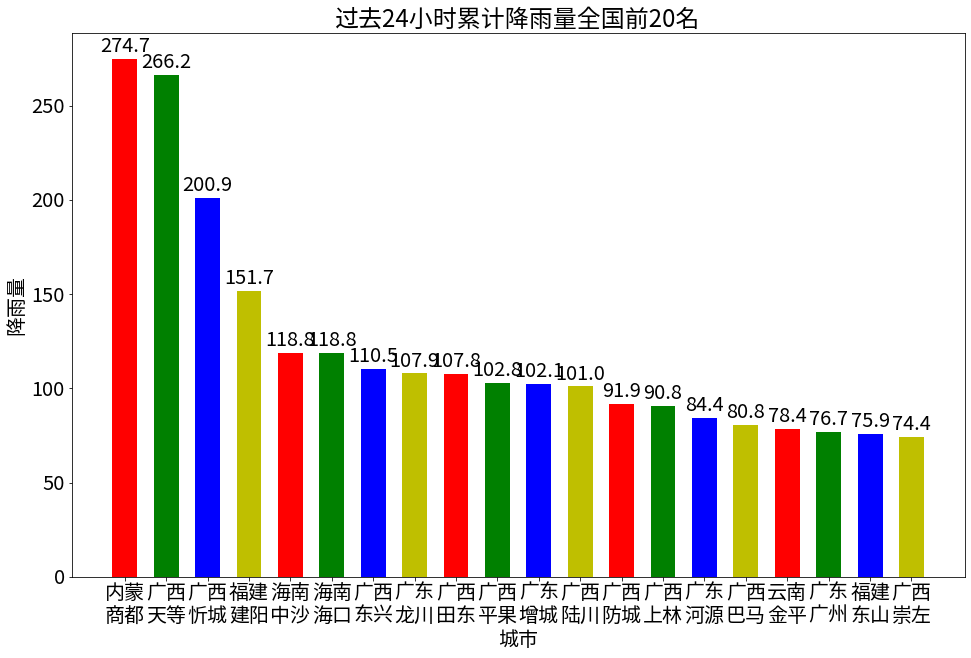

In [88]:
draw_rain(df_rain24_sum.head(20))

In [137]:
def draw_temperature(temp_list, title):
    name_l = []
    num_l = []
    date = temp_list[0].date
    for item in temp_list:
        name_l.append(item.province[0:2]+'\n'+item.city_name)
        num_l.append(item.avg_temperature)
    index = [i+0.25 for i in range(len(num_l))]
    rects = plt.bar(index, num_l, color='rgby', width=0.6)
    plt.xticks(index, name_l)
    # plt.xticks([i+0.25 for i in index], name_l)
    # plt.ylim(ymax = math.ceil(float(max(num_l))), ymin = 0)
    plt.xlabel('城市')
    plt.ylabel('日平均气温')
    plt.title('{date}{title}'.format(date=date, title=title))
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2, height+.1, f"{height:.1f}", ha="center", va='bottom')
    plt.show()

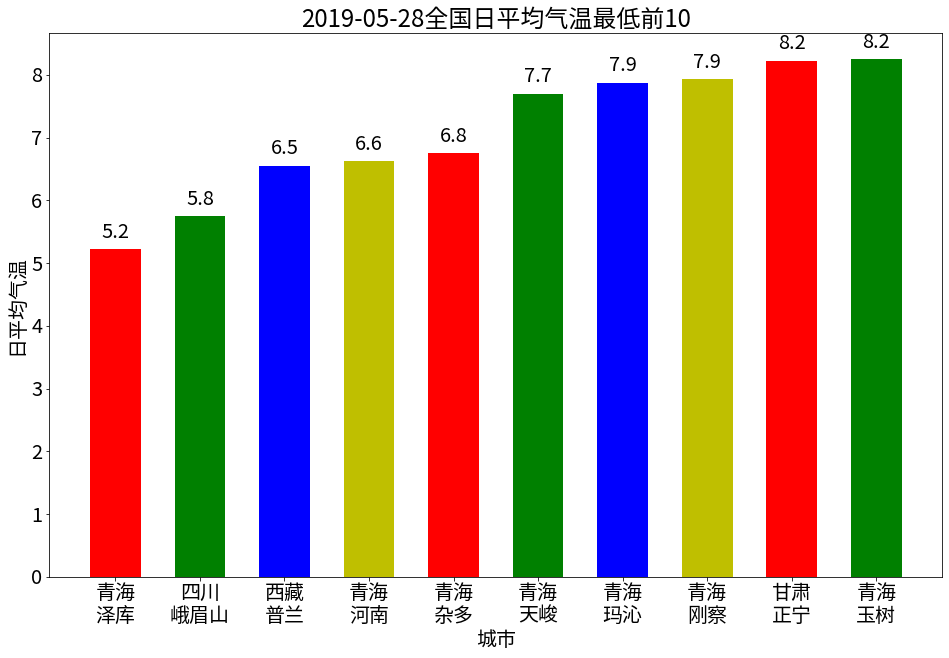

In [138]:
draw_temperature(avg_temperature_list[:10], "全国日平均气温最低前10")

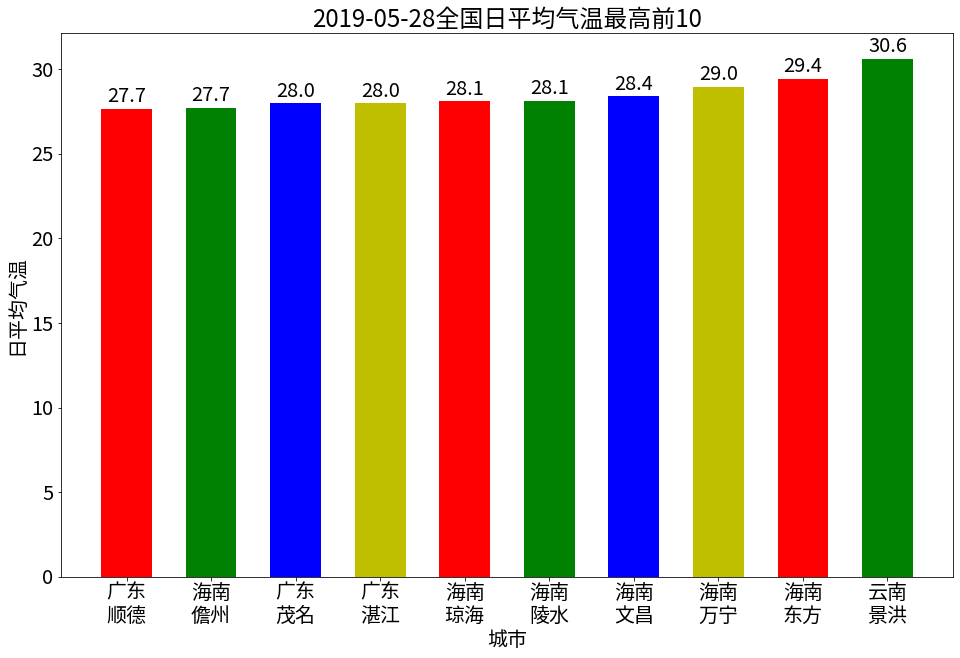

In [150]:
draw_temperature(avg_temperature_list[-10:], "全国日平均气温最高前10")